# Case Study: PCR Thermal Cycler Protocols

The goal of this next section is to create a function that returns the value of a setpoint profile for a PCR thermal cycler. We'll break this into a series of steps:

* Specify a PCR protocol
* Convert the PCR protocol in a sequence of ramp and soak periods
* Create a function that returns the value of setpoint at any point in time
* Create a function that returns a setpoint function.

## Typcial PCR thermal cycler protocols

Here's an example of a PCR thermal cycler protocol:

* Activation of polymerase: 95°C, 15 min
* Thermal cycling: 30 cycles
    * Denaturation: 94°C, 20 s
    * Annealing: 60°C, 20 s
    * Elongation: 72°C, 30 s
* Extension: 72°C, 10 min
* Storage: 4°C, as necessary

The details of these protocols vary depending on the nature of the test, the reagents used, and the type of detection that will be employed. In real-time PCR, the number of cycling steps will end once a positive result is obtained.

## Representing PCR protocols in Python

The PCR protocol is a series of (time, temperature) pairs. The code in the next cell represents a protocol as a sequence of (time, temperature) pairs in a Python list. The list is constructed by concatenating subprotocols denoting the activation, cycling and extension steps in a PCR protocol

In [6]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

# number of cycles
n_cycles = 5

# enter steps in the protocol as a list of (time, temperature) pairs
activation = [(900, 95)]
cycling = [(20, 94), (20, 60), (30, 72)]*n_cycles
extension = [(600, 72)]
finish = [[0, 30]]

# concatenate into a list of (time, temperature) intervals
protocol = np.concatenate([activation, cycling, extension, finish])
protocol

array([[900,  95],
       [ 20,  94],
       [ 20,  60],
       [ 30,  72],
       [ 20,  94],
       [ 20,  60],
       [ 30,  72],
       [ 20,  94],
       [ 20,  60],
       [ 30,  72],
       [ 20,  94],
       [ 20,  60],
       [ 30,  72],
       [ 20,  94],
       [ 20,  60],
       [ 30,  72],
       [600,  72],
       [  0,  30]])

## Converting to ramp, soak specifications

Each step in a PCR protocol consists of an initial ramp to the specified temperature, followed by a soak for the specified time and temperature. We begin the coding by demonstrating how to interpret the protocol specification as a series of ramp and soak periods.

In [7]:
# each soak period is preceeded by a ramp
for time, temp in protocol:
    print(f"Ramp to {temp}C")
    print(f"Soak at {temp}C for {time:3d} seconds." )

Ramp to 95C
Soak at 95C for 900 seconds.
Ramp to 94C
Soak at 94C for  20 seconds.
Ramp to 60C
Soak at 60C for  20 seconds.
Ramp to 72C
Soak at 72C for  30 seconds.
Ramp to 94C
Soak at 94C for  20 seconds.
Ramp to 60C
Soak at 60C for  20 seconds.
Ramp to 72C
Soak at 72C for  30 seconds.
Ramp to 94C
Soak at 94C for  20 seconds.
Ramp to 60C
Soak at 60C for  20 seconds.
Ramp to 72C
Soak at 72C for  30 seconds.
Ramp to 94C
Soak at 94C for  20 seconds.
Ramp to 60C
Soak at 60C for  20 seconds.
Ramp to 72C
Soak at 72C for  30 seconds.
Ramp to 94C
Soak at 94C for  20 seconds.
Ramp to 60C
Soak at 60C for  20 seconds.
Ramp to 72C
Soak at 72C for  30 seconds.
Ramp to 72C
Soak at 72C for 600 seconds.
Ramp to 30C
Soak at 30C for   0 seconds.


The next step is to introduce a ramp rate and add variables to track the start time and temperature for each segment. We will assume all ramp rates have the same absolute value.

In [8]:
# add varibles to track current time and temperature
# ramp period is determined by a "ramp_rate"
ramp_rate = 2.5
time_now = 0.0
temp_now = 21.0

for time, temp in protocol:
    print(f"Time = {time_now:6.1f}: Ramp to {temp}C")
    time_now += np.abs((temp - temp_now)/ramp_rate) 
    temp_now = temp
    print(f"Time - {time_now:6.1f}: Soak at {temp}C for {time} seconds")
    time_now += time

Time =    0.0: Ramp to 95C
Time -   29.6: Soak at 95C for 900 seconds
Time =  929.6: Ramp to 94C
Time -  930.0: Soak at 94C for 20 seconds
Time =  950.0: Ramp to 60C
Time -  963.6: Soak at 60C for 20 seconds
Time =  983.6: Ramp to 72C
Time -  988.4: Soak at 72C for 30 seconds
Time = 1018.4: Ramp to 94C
Time - 1027.2: Soak at 94C for 20 seconds
Time = 1047.2: Ramp to 60C
Time - 1060.8: Soak at 60C for 20 seconds
Time = 1080.8: Ramp to 72C
Time - 1085.6: Soak at 72C for 30 seconds
Time = 1115.6: Ramp to 94C
Time - 1124.4: Soak at 94C for 20 seconds
Time = 1144.4: Ramp to 60C
Time - 1158.0: Soak at 60C for 20 seconds
Time = 1178.0: Ramp to 72C
Time - 1182.8: Soak at 72C for 30 seconds
Time = 1212.8: Ramp to 94C
Time - 1221.6: Soak at 94C for 20 seconds
Time = 1241.6: Ramp to 60C
Time - 1255.2: Soak at 60C for 20 seconds
Time = 1275.2: Ramp to 72C
Time - 1280.0: Soak at 72C for 30 seconds
Time = 1310.0: Ramp to 94C
Time - 1318.8: Soak at 94C for 20 seconds
Time = 1338.8: Ramp to 60C
Time -

## Finding the start and finish of each segment

Finally, we create a two column numpy array representing the setpoint profile. The first row in the array is the starting time and temperature. Each subsequent row constains the ending time and temperature of a segment.

In [9]:
# store the data in a list of time, temperature pairs marking the end of each period

ramp_rate = 0.5 # deg/sec
time_now = 0.0
temp_now = 21.0

# intialze a list with the starting time and temperature
SP_list = [[time_now, temp_now]]

# append the ending time and temperature to the list
for time, temp in protocol:
    # ramp
    time_now += np.abs((temp - temp_now)/ramp_rate) 
    temp_now = temp
    SP_list.append([time_now, temp_now])

    # soak
    time_now += time
    SP_list.append([time_now, temp_now])

# convert list to numpy array to access columns
SP_array = np.array(SP_list)
SP_array

array([[   0.,   21.],
       [ 148.,   95.],
       [1048.,   95.],
       [1050.,   94.],
       [1070.,   94.],
       [1138.,   60.],
       [1158.,   60.],
       [1182.,   72.],
       [1212.,   72.],
       [1256.,   94.],
       [1276.,   94.],
       [1344.,   60.],
       [1364.,   60.],
       [1388.,   72.],
       [1418.,   72.],
       [1462.,   94.],
       [1482.,   94.],
       [1550.,   60.],
       [1570.,   60.],
       [1594.,   72.],
       [1624.,   72.],
       [1668.,   94.],
       [1688.,   94.],
       [1756.,   60.],
       [1776.,   60.],
       [1800.,   72.],
       [1830.,   72.],
       [1874.,   94.],
       [1894.,   94.],
       [1962.,   60.],
       [1982.,   60.],
       [2006.,   72.],
       [2036.,   72.],
       [2036.,   72.],
       [2636.,   72.],
       [2720.,   30.],
       [2720.,   30.]])

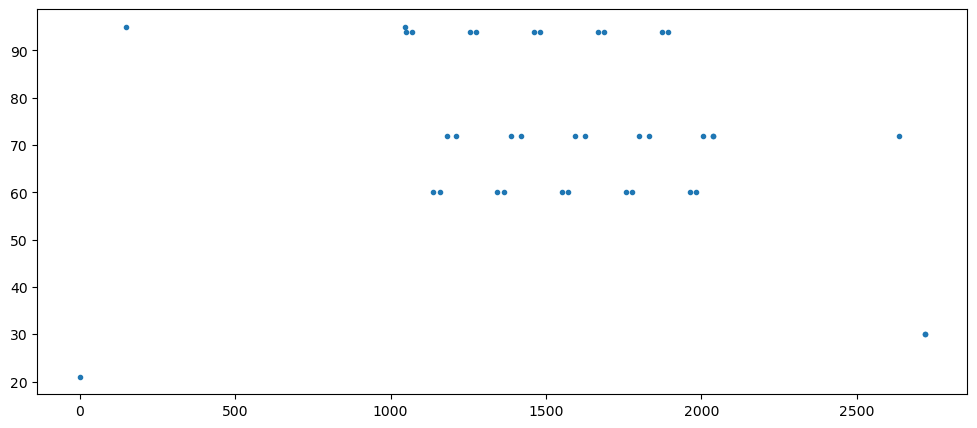

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(12, 5))
ax.plot(SP_array[:,0], SP_array[:,1], '.')

## Finding the setpoint function by interpolating the start and end of each segment

To implement control algorithms we will need to find values of the setpoint function at arbitrary points in time, not just at the start and finish of ramp or soak periods. The standard numpy library includes a linear interpolation function [`numpy.interp`](https://numpy.org/doc/stable/reference/generated/numpy.interp.html) well suited to this purpose.

Text(0.5, 1.0, 'Setpoint function')

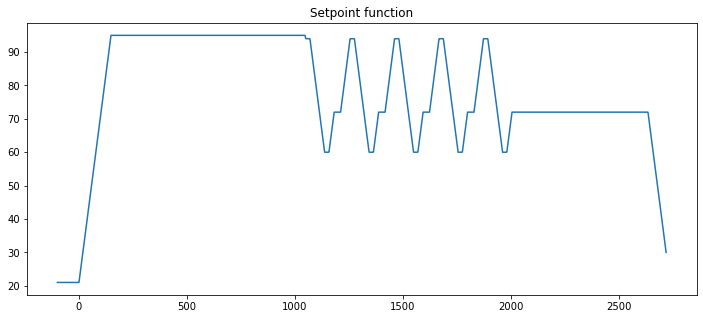

In [56]:
# create function to interpolate

def SP(t):
    return np.interp(t, SP_array[:,0], SP_array[:, 1])

# plotting the setpoint function
t = np.linspace(-100, max(SP_array[:,0]), 2000)
fig, ax = plt.subplots(1, 1, figsize=(12,5))
ax.plot(t, SP(t))
ax.set_title("Setpoint function")

## Creating a setpoint function for PCR thermal cycler

The last step is to put all of these steps together to create a function that generates a setpoint function. This is an example of a very powerful coding technique of [nested functions](https://realpython.com/inner-functions-what-are-they-good-for/).

Text(0.5, 1.0, 'Setpoint function')

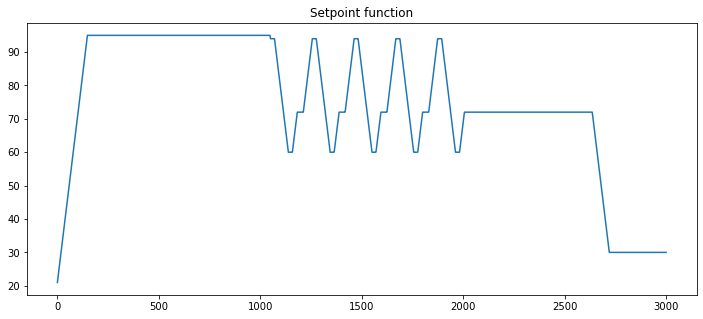

In [57]:
# create the setpoint function from a specified PCR 
def PCR_setpoint(protocol):
    
    ramp_rate = 0.5 # deg/sec
    time_now = 0.0
    temp_now = 21.0

    # intialze a list with the starting time and temperature
    SP_list = [[time_now, temp_now]]

    # append the ending time and temperature to the list
    for time, temp in protocol:
        # ramp
        time_now += np.abs((temp - temp_now)/ramp_rate) 
        temp_now = temp
        SP_list.append([time_now, temp_now])

        # soak
        time_now += time
        SP_list.append([time_now, temp_now])

    # convert list to numpy array to access columns
    SP_array = np.array(SP_list)
    
    def SP(t):
        return np.interp(t, SP_array[:,0], SP_array[:, 1])

    return SP

# create a setpoint function
setpoint = PCR_setpoint(protocol)

# plotting the setpoint function
t = np.linspace(0, 3000, 3000)
fig, ax = plt.subplots(1, 1, figsize=(12,5))
ax.plot(t, setpoint(t))
ax.set_title("Setpoint function")

<hr>

**Study Question:** Change the protocol to include 30 thermal cycles, then create the setpoint function with `PCR_setpoint()` and plot the results.

**Study Question:** To better reflect the unequal heating and cooling rates available in most PCR devices, modify `PCR_setpoint()` to provide differing ramp rates for positive going and negative going ramps. Demonstrate the result using a postive ramp_rate of 2.5 degC/sec and a negative ramp_rate of -0.5 degC/sec.

<hr>